In [33]:
import os
if not os.getcwd().endswith('CIoTS'):
    os.chdir('../..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from CIoTS import *

# Execution

## Data generation

In [20]:
from itertools import product

dimensions = [3,4,5]
incoming_edges = [3]
taus = [5, 10, 15]
autocorr = [0.75]
data_length = [1000]
runs = range(5)

setups = list(product(dimensions, incoming_edges, taus, autocorr, data_length, runs))

In [28]:
import pickle
data_path = 'notebooks/ICML/icml_data/'

for dim, in_edges, tau, autocorr, data_length, run in setups:
    generator = CausalTSGenerator(dimensions=dim, max_p=tau, data_length=data_length,
                                  incoming_edges=in_edges, autocorrelation=autocorr)
    ts = generator.generate()
    pickle.dump(generator, open(data_path + f't={tau}_d={dim}_in={in_edges}_{run}.pickle', 'wb'))

## 1. Compute $F_1$ for known $\tau$

PC1 iterative vs. PC1 non-iterative

Also check for $\tau - k$ and $\tau + k$ to visualize importance of $\tau$ estimation

In [29]:
data_path = 'notebooks/ICML/icml_data/'
results_path = 'notebooks/ICML/icml_results/'
results = pd.DataFrame()

algorithms = [pc_incremental, pc_incremental_pc1]

for dim, in_edges, tau, _, _, run in setups[:1]:
    generator = pickle.load(open(data_path + f't={tau}_d={dim}_in={in_edges}_{run}.pickle', 'rb'))
    
    df_dict = {'dimension': dim, 'max time lag': tau, 'incoming edges': in_edges, 'run': run}
    for algorithm in algorithms:
        pred_graph = algorithm(partial_corr_test, generator.ts, alpha=0.05, p_max=40, 
                               verbose=False, patiency=20)
        f1_score = evaluate_edges(generator.graph, pred_graph)['f1-score']
        df_dict[algorithm.__name__ + '_f1'] = f1_score

    results = results.append(df_dict, ignore_index=True)

results.to_csv(results_path + f'experiment1.csv')

In [34]:
dim, in_edges, tau, _, _, run = setups[0]
generator = pickle.load(open(data_path + f't={tau}_d={dim}_in={in_edges}_{run}.pickle', 'rb'))

[]

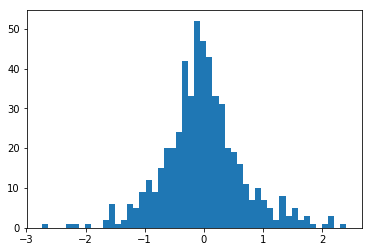

In [54]:
weights = []
for dim, in_edges, tau, _, _, run in setups:
    generator = pickle.load(open(data_path + f't={tau}_d={dim}_in={in_edges}_{run}.pickle', 'rb'))
    weights.extend([generator.graph.edges[edge]['weight'] for edge in generator.graph.edges() if generator.graph.edges[edge]['weight'] != 0.75])
plt.hist(weights, bins=50)
plt.plot()

[]

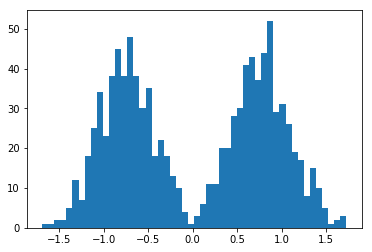

In [108]:
import random
rd_data = []
for _ in range(1000):
    
plt.hist(rd_data, bins=50)
plt.plot()

## 2. Compute estimate $\hat{\tau}$ for unknown $\tau$

# Visualization

## 1. Visualize $F_1$ for known $\tau$

## 2. Visualize estimate $\hat{\tau}$ for unknown $\tau$